Experience replay
Network of fully connected layers w/ dimension 12 6 3 1 w/tanh activation w/ linear activation for output w/adam optimizer w/ learning rate 0.0001.

Area = random(500*500)
n_vehicles = 3
n_nodes = random(8-20)

node_list = [len(n_nodes)]

### Set random node locations
for nodes in range(n_nodes):
    location_node = [0, 0]
    location_node[0], location_node[1] = random(1, 499), random(1, 499) 
    append to node list

location_depot

Descriptipn:
    A capacitated, electric vehice routing problem with n drones and m nodes, distances between each node and demands for each node. ALl drones start form the central depot node and must deliver the complete demand to nodes.
    
Observation:
    Type: Dict(3)
    
    Key      Description                    Min          Max        Shape
    
    Drones   Pos_x, Pox_y, Cap_Current,    [-100, -100 0, 0] [100, 20, 200] [] 
             Charge_Current, List_Del...

    Nodes    Pos_x, Pox_y, Demand,         [-100, -100, 0, 0, 0] [100, 5, 120, 1]
             Charger
    
    Obstr... Position,                    [-100]       [100]

Actions:
    Type: Discrete(5)
    
    Num Action
    
    0   Do Nothing
    1   Accept order i for drone 1
    2   Accept order i for drone 2
    3   Accept order i for drone 3
    4   Accept order i for drone 4
    
Reward:
    ???
    
Starting State:
    ???
    
Episode Termination:
    ???

# 0. Pseudo Code

# 1. Import Dependencies

In [97]:
import sys
import os
from typing import Dict
from scipy.spatial import distance_matrix
import pandas as pd
import math
import gym
import random
from gym import Env, logger, spaces
import numpy as np
import matplotlib.pyplot as plt
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
#!{sys.executable} -m pip install [module_name]

# 2. Create Environment

In [98]:
drones_min = np.array([[-100, -100, 0, 0],
                    [-100, -100, 0, 0],
                    [-100, -100, 0, 0],
                    [-100, -100, 0, 0]])
drones_max = np.array([[100, 100, 20 ,200],
                     [100, 100, 20 ,200],
                     [100, 100, 20 ,200],
                     [100, 100, 20 ,200]])
nodes_min = np.array([[-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0],
                    [-100, -100, 0, 0, 0]])
nodes_max = np.array([[100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1],
                    [100, 100, 5, 120, 1]])
obstructions_min = np.array([-100, -100])
obstructions_max = np.array([100, 100])

,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,node_10,node_11,node_12
node_1,0.000000,89.442719,28.017851,59.033889,51.088159,59.808026,108.226614,60.827625,57.801384,43.185646,34.234486,76.295478
node_2,89.442719,0.000000,105.759160,126.035709,119.205705,149.053682,146.536685,122.065556,31.953091,84.053554,76.236474,132.593363
node_3,28.017851,105.759160,0.000000,79.056942,71.867934,55.443665,132.423563,82.855296,76.485293,33.015148,62.201286,49.335586
node_4,59.033889,126.035709,79.056942,0.000000,8.062258,58.855756,56.089215,8.062258,96.332757,102.176318,50.089919,127.059041
node_5,51.088159,119.205705,71.867934,8.062258,0.000000,56.612719,61.684682,11.401754,89.089842,94.260278,43.011626,120.303782
node_6,59.808026,149.053682,55.443665,58.855756,56.612719,0.000000,113.004425,66.490601,117.200683,88.362888,81.394103,88.408144
node_7,108.226614,146.536685,132.423563,56.089215,61.684682,113.004425,0.000000,50.289164,124.169239,150.206524,84.172442,181.466250
node_8,60.827625,122.065556,82.855296,8.062258,11.401754,66.490601,50.289164,0.000000,93.214806,103.947102,47.074409,131.518060
node_9,57.801384,31.953091,76.485293,96.332757,89.089842,117.200683,124.169239,93.214806,0.000000,60.728906,46.270941,110.054532
node_10,43.185646,84.053554,33.015148,102.176318,94.260278,88.362888,150.206524,103.947102,60.728906,0.000000,68.942005,49.396356


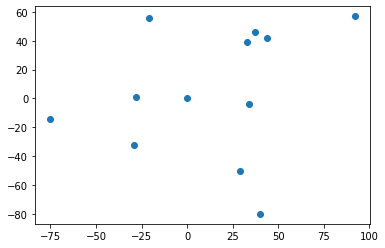

In [99]:
np.random.seed(1)
x_cord = np.random.randint(-100, 100, 12)
y_cord = np.random.randint(-100, 100, 12)
# Ddd depot node at 0, 0
x_cord[0], y_cord[0] = 0, 0

node_cord = np.zeros([12, 2], dtype = int)

for i in range(12):
    
    node_cord[i] = [x_cord[i],y_cord[i]]

tags = ["node_1", "node_2", "node_3", "node_4", "node_5", "node_6", "node_7", "node_8", "node_9", "node_10", "node_11", "node_12", ]
node_cord_df = pd.DataFrame(node_cord, columns = ["x_cord", "y_cord"], index = tags)
node_distance_matrix = pd.DataFrame(distance_matrix(node_cord_df.values, node_cord_df.values), index = node_cord_df.index, columns = node_cord_df.index)
plt.scatter(x_cord, y_cord)
plt.show
pd.DataFrame(distance_matrix(node_cord_df.values, node_cord_df.values), index = node_cord_df.index, columns = node_cord_df.index)

In [100]:
# update drone(cap, chg, list) and node()
def update_environment(state, n_drone, n_node):
    
    d_positions = state["d_position"]
    d_capacities = state["d_capacity"]
    d_charges = state["d_charge"]
    d_routes = state["d_route"]

    n_positions = state["n_position"]
    n_demands = state["n_demand"]
    n_charger = state["n_charger"]
    n_matrix = state["n_matrix"]
    
    d_routes.astype(object)
    #print("n_matrix type is :{}".format(type(n_matrix[n_node, d_routes[len(d_routes)-1]])))
    #print("X N_ node is:{}".format(n_node))
    #print("Type of len is:{}".format(type(len(d_routes)-1)))
    #print("Type of d_routes[len(d_routes)-1] is:{}".format(type(d_routes[len(d_routes)-1])))
    #print("d_routes len is:{}".format(d_routes[len(d_routes)-1]))
    #print("Y d_routes is:{}".format(d_routes[len(d_routes)-1]))
    #print(n_matrix[n_node, d_routes[len(d_routes)-1]])

    has_capacity = False
    has_charge = False
    available = False
    # check if there's available capacity
    if d_capacities[n_drone] >= n_demands[n_node]:
        has_capacity = True
        #print("has cap")

        # decrease capacity 
        d_capacities[n_drone] -= n_demands[n_node]
    else:
        #print("no cap")
        d_capacities[n_drone] = 0
    
    # check if there's avaiable charge
    a = d_charges[n_drone]
    b = n_matrix[n_node, d_routes[len(d_routes)-1]]
    #if d_charges[n_drone] >= n_matrix[n_node, d_routes[len(d_routes)-1]]:
    if (a>b.any()):
        has_charge = True
        #print("has charge")
    
        # decrease charge
        temp = d_routes[n_drone-1]
        d_charges[n_drone] -= n_matrix[n_node, temp[-1]]
    else:
        #print("no charge")
        d_charges[n_drone] = 0
    # check if both conditions are True
    if has_capacity and has_charge == True:
        #print("available")
        available = True
        
        # add node to drone list
        #d_routes = np.insert(d_routes,len(d_routes[n_node]), n_node, action)
        #print(type(d_routes))
        #np.insert(d_routes,)
    
        
        #np.append(d_routes[n_node], n_node)
        #print(d_routes)
        if len(d_routes) == 5:
            d_routes = d_routes[1:5]
        else:
            pass
        
        row = d_routes[n_drone]
        index = np.where( row == 0)[0]
        d_routes[n_drone, index[1]] = n_node
        
        #d_routes = d_routes[n_node,len(d_routes[n_node])]
        #np.append(d_drone, n_node) 
    state = {"d_position": d_positions,
          "d_capacity": d_capacities,
          "d_charge": d_charges,
          "d_route": d_routes,
          "n_position": n_positions,
          "n_demand": n_demands,
          "n_charger": n_charger,
          "n_matrix": n_matrix}       
    
    #print("is going from {} to {}".format(d_routes[len(d_routes)-2],d_routes[len(d_routes)-1]))
    return state, available

for every step where not every demand is met/not enough fuel/going to old position -reward


In [115]:
class VrpEnv(Env):
    def render(self):
         pass
    
    def __init__(self, n_drones = 4, 
                 n_nodes = 12, 
                 drone_capacity = 200,):
                
        self.observation_space = spaces.Dict(
        {
            "d_position": spaces.Box(low = np.array([[-100, -100], [-100, -100], [-100, -100],[-100, -100]]), high = np.array([[100, 100], [100, 100], [100, 100], [100, 100]]), shape = (4, 2), dtype = int),
            "d_capacity": spaces.Box(low = np.array([0, 0, 0, 0]), high = np.array([200, 200, 200, 200]), shape = (4,), dtype = int),
            "d_charge": spaces.Box(low = np.array([0, 0, 0, 0]), high = np.array([20, 20, 20, 20]), shape = (4,), dtype = float),
            "d_route": spaces.Box(low = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), high = np.array([[12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12], [12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12], [12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12], [12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12 ,12]]), shape = (4, 12), dtype = int),
            "n_position": spaces.Box(low = np.array([[-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100], [-100, -100]]), high = np.array([[100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100]]), shape = (12, 2), dtype = int),
            "n_demand": spaces.Box(low = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), high = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]), shape = (12,), dtype = int),
            "n_charger": spaces.Box(low = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), high = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), shape = (12, ), dtype = int),
            "n_matrix": spaces.Box(low = np.array([[0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0]]), high = np.array([[283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283],
                            [283, 283, 283, 283 , 283, 283, 283, 283, 283, 283, 283, 283]]), shape = (12,12), dtype = float)
            })
        
        self.action_space = spaces.Discrete(4)
        
    def step(self, action):
        
        done = False
        self.reward = 0
        self.timer -= 1
        self.n_node += 1
        if self.n_node == 11:
            done = True
                    
     # or do update_environment(...,action)     
        #if action == 0:
            #pass
        
     # Sign node i for drone [action]
        #else:
            #update_environment(drones, nodes, action, self.n_node)
        #print("Drone {}".format(action))
        #print("this is node:{}".format(self.n_node))
        self.state, available = update_environment(self.state, action, self.n_node)
        
     # Adjust reward based on charge
     # Adjust reward based on demands met
        if available == False:
            self.reward -= 1
    
        info = {}
        
        #print("Drone {}: Going from {} to {}".format(action, self.n_node, self.n_node))
        #print(self.state_drones["route"])
        #print(type(self.state[]))
        #print(drones)
        
        return self.state, self.reward, done, info

    def reset(self):
        self.timer = 120
        self.n_node = 0
        
        np.random.seed()
        x_cord = np.random.randint(-100, 100, 12)
        y_cord = np.random.randint(-100, 100, 12)
        # Ddd depot node at 0, 0
        x_cord[0], y_cord[0] = 0, 0

        node_cord = np.zeros([12, 2], dtype = int)

        for i in range(12):
    
            node_cord[i] = [x_cord[i],y_cord[i]]

        tags = ["node_1", "node_2", "node_3", "node_4", "node_5", "node_6", "node_7", "node_8", "node_9", "node_10", "node_11", "node_12", ]
        node_cord_df = pd.DataFrame(node_cord, columns = ["x_cord", "y_cord"], index = tags)
        node_distance_matrix = pd.DataFrame(distance_matrix(node_cord_df.values, node_cord_df.values), index = node_cord_df.index, columns = node_cord_df.index).to_numpy()

    
        self.state = {"d_position": np.array([[0, 0], [0, 0], [0, 0], [0, 0]]),
                          "d_capacity": np.array([200, 200, 200, 200]),
                          "d_charge": np.array([20, 20, 20, 20]),
                          "d_route": np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
                          "n_position": np.array([[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ]),
                          "n_demand": np.array([0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0]),
                          "n_charger": np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
                          "n_matrix": node_distance_matrix}
        
        return self.state

In [116]:
np.random.seed()
x_cord = np.random.randint(-100, 100, 12)
y_cord = np.random.randint(-100, 100, 12)
# Ddd depot node at 0, 0
x_cord[0], y_cord[0] = 0, 0

node_cord = np.zeros([12, 2], dtype = int)

for i in range(12):
    
    node_cord[i] = [x_cord[i],y_cord[i]]

tags = ["node_1", "node_2", "node_3", "node_4", "node_5", "node_6", "node_7", "node_8", "node_9", "node_10", "node_11", "node_12", ]
node_cord_df = pd.DataFrame(node_cord, columns = ["x_cord", "y_cord"], index = tags)
node_distance_matrix = pd.DataFrame(distance_matrix(node_cord_df.values, node_cord_df.values), index = node_cord_df.index, columns = node_cord_df.index).to_numpy()
print(type(node_distance_matrix))

<class 'numpy.ndarray'>


# 3. Test Environment

In [120]:
env = VrpEnv()
episodes = 5
for episode in range(1, episodes+1):
    score = 0
    done = False
    obs = env.reset()
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
    print("Episode:{}, Score:{}".format(episodes, score))
        

Episode:5, Score:-8
Episode:5, Score:-7
Episode:5, Score:-7
Episode:5, Score:-7
Episode:5, Score:-7


C:\Users\Msi\Projects\IRP\VRP\venv_reinforcement_learning\venv1\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(


# 4. Train Model

In [121]:
log_path = os.path.join("Training", "Logs")
model = PPO("MultiInputPolicy",
           env,
           verbose = 1,
           tensorboard_log = log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [122]:
model.learn(total_timesteps = 10000)

Logging to Training\Logs\PPO_24
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11       |
|    ep_rew_mean     | -7.1     |
| time/              |          |
|    fps             | 1658     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | -7.04        |
| time/                   |              |
|    fps                  | 1170         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0053551076 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   

# 5. Evaluate Model